In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
from matplotlib import lines
import pickle as pkl
from utils import u_plot as uplot, constants as cnst, u_darrays, u_met
import pandas as pd
import os
from utils import u_statistics as u_stat
import glob
import matplotlib as mpl

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd /home/ck/pythonWorkspace/proj_CEH/

/home/ck/pythonWorkspace/proj_CEH


In [14]:
def linear_trend_lingress(x, nb_missing=None, sig=None):
    
    
    coll = []
    x = x.squeeze()

    for xx in x.transpose():
    
        slope, intercept, r, p, std_err = stats.linregress(np.arange(len(xx.values)), xx.values)

        # we need to return a dataarray or else xarray's groupby won't be happy

        if nb_missing is not None:
            if np.nansum(xx.values==0)>=10:
                p = np.nan
                slope = np.nan
        
        if sig is not None:
            if p > sig:
                slope = np.nan
        
        coll.append(slope)
    
    return xr.DataArray(coll,)

In [44]:
def linear_trend_lingress_single(x, nb_missing=None, sig=None):
    
    x = x.squeeze()

    slope, intercept, r, p, std_err = stats.linregress(np.arange(len(x.values)), x.values)

        # we need to return a dataarray or else xarray's groupby won't be happy

    if nb_missing is not None:
        if np.nansum(x.values==0)>=10:
            p = np.nan
            slope = np.nan

    if sig is not None:
        if p > sig:
            slope = np.nan
        
    
    return xr.DataArray(slope,)

In [16]:
def linear_trend_lingress_2d(x, nb_missing=None, sig=None, method=None):
    
    
    # stack lat and lon into a single dimension called allpoints
    datastacked = x.stack(allpoints=['latitude', 'longitude'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_lingress,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = np.nan
            
    return dtrend['slope']

In [17]:
filepath  = cnst.network_data + 'data/CLOVER/chris_input/'
file = filepath + 'zonal_mean_10W_10E_trend_1deg_70C_GridSat_cdr_1800_monthly.gra'

In [18]:
file

'/home/ck/DIR/cornkle/data/CLOVER/chris_input/zonal_mean_10W_10E_trend_1deg_70C_GridSat_cdr_1800_monthly.gra'

In [19]:
def readFile(bfile, nx, ny, nz,nt, nvars): #1,72,2,12,5
    if not os.path.isfile(bfile):
        return np.array([False])
    
    rrShape = (nt, nz, ny, nx, nvars)  # msg shape
    rrMDI = np.float32(13.5)#rrMDI = np.uint8(255)
    rr = np.fromfile(bfile, dtype=rrMDI.dtype)
    
    rr.shape = rrShape
    ipdb.set_trace()
    msg_latlon = np.load(llfile)

    mlon = msg_latlon['lon']
    mlat = msg_latlon['lat']

    msg_obj = {'t': rr, 'lons': mlon, 'lats': mlat}  # lats lons numpy arrays!

    return msg_obj

In [20]:
arr = np.array([12,5,2,72])  # read chris MCS trend file month, variable, MCS type, latitude (-34.5, 1deg steps)
rrMDI = np.float32(13.5)#rrMDI = np.uint8(255)
rr = np.fromfile(file, dtype=rrMDI.dtype)
rr.shape = tuple(arr)
rr[rr<-900] = np.nan
tgrad = rr[:,1,0,:]*10
tmean = rr[:,2,0,:]
ttest = rr[:,4,0,:]

In [21]:
ttest = xr.DataArray(ttest.T, coords={'lat' :  np.arange(-34.5,-34.5+72*1,1), 'month' : np.arange(1,13,1) }, dims=['lat', 'month'])

In [22]:
da = xr.DataArray(tgrad.T, coords={'lat' :  np.arange(-34.5,-34.5+72*1,1), 'month' : np.arange(1,13,1) }, dims=['lat', 'month'])

In [23]:
mean = xr.DataArray(tmean.T, coords={'lat' :  np.arange(-34.5,-34.5+72*1,1), 'month' : np.arange(1,13,1) }, dims=['lat', 'month'])

In [24]:
da = da.where(ttest.values>=1.697)  # p < 0.05, 5000km2 MCS -70C

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


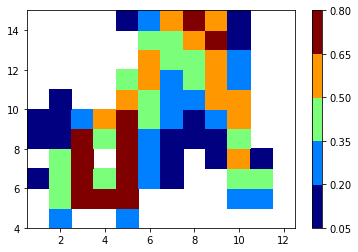

In [25]:
f = plt.figure()
ax = f.add_subplot(111)
cmapp = uplot.discrete_cmap(5, base_cmap='jet')
mappable = plt.pcolormesh(np.arange(0.5,13,1), np.arange(4,16,1),da.sel(lat=slice(4,15)).values,cmap=cmapp, vmin=0.05, vmax=0.80)
cbar = f.colorbar(mappable, ticks=np.linspace(0.05,0.80,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('')
# -70 MCS >25000km2 trends 

In [26]:
da.sel(lat=slice(4,15)).shape

(11, 12)

In [27]:
era_srfc = xr.open_dataset(cnst.ERA_MONTHLY_SRFC)
era_pl = xr.open_dataset(cnst.ERA_MONTHLY_PL)
ccover = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_count_5000km2.nc')

In [28]:
era_srfc = u_darrays.flip_lat(era_srfc)
era_pl = u_darrays.flip_lat(era_pl)

In [29]:
# ws_ar = u_met.u_v_to_ws_wd(era_pl['u'].values, era_pl['v'].values)
# era_pl['v'].values = ws_ar[0]

era_trend = era_pl.sel(longitude=slice(-10,10), latitude=slice(0,25)).squeeze().mean('longitude')
ccover_trend = ccover['tir'].sel(lon=slice(-10,10), lat=slice(0,25)).squeeze().mean('lon')

In [30]:
utrend = era_trend['u'][era_trend['time.year']>1982].sel(level=925).squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10)*10

vtrend = era_trend['v'][era_trend['time.year']>1982].sel(level=925).squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10)*10

qtrend = era_trend['q'][era_trend['time.year']>1982].sel(level=slice(924,925)).mean('level').squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10, sig=0.05)*10*1000

qtrend_ns = era_trend['q'][era_trend['time.year']>1982].sel(level=slice(924,925)).mean('level').squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10)*10*1000

ttrend = era_trend['t'][era_trend['time.year']>1982].sel(level=925).squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10)*10

shear_u = era_trend['u'][era_trend['time.year']>1982].sel(level=slice(600,700)).min(dim='level')-era_trend['u'].sel(level=slice(850,925)).max(dim='level')
shear_v = era_trend['v'][era_trend['time.year']>1982].sel(level=slice(600,700)).min(dim='level')-era_trend['v'].sel(level=slice(850,925)).max(dim='level')
ws_shear = u_met.u_v_to_ws_wd(shear_u.values, shear_v.values)
shear = era_trend['u'][era_trend['time.year']>1982].sel(level=925)
shear.name = 'shear'
shear.values = ws_shear[0]
strend_ns = shear.squeeze().groupby('time.month').apply(linear_trend_lingress,nb_missing=10)*10

ctrend = ccover_trend.groupby('time.month').apply(linear_trend_lingress,nb_missing=10, sig=0.05)*10

In [31]:
np.unique((era_trend['t']['time.year']))

array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017])

In [32]:
ccover_trend

<xarray.DataArray 'tir' (time: 420, lat: 358)>
array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.017483, 0.017483, 0.027972, ..., 0.      , 0.      , 0.      ],
       ...,
       [0.020979, 0.024476, 0.020979, ..., 0.      , 0.      , 0.      ],
       [0.006993, 0.01049 , 0.01049 , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 0.0 0.069999695 0.13999939 ... 24.919998 24.989998
  * time     (time) datetime64[ns] 1983-01-31 1983-02-28 ... 2017-12-31

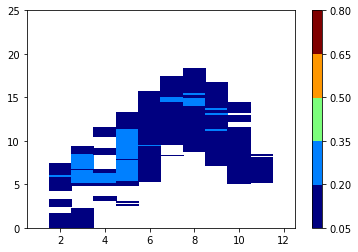

In [33]:
f = plt.figure()
ax = f.add_subplot(111)
cmapp = uplot.discrete_cmap(5, base_cmap='jet')
mappable = plt.pcolormesh(np.arange(0.5,13,1), ccover_trend.lat,ctrend.transpose(),cmap=cmapp, vmin=0.05, vmax=0.80)
cbar = f.colorbar(mappable, ticks=np.linspace(0.05,0.80,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('')
# -70 MCS >25000km2 trends 

In [34]:
umean = era_trend['u'][era_trend['time.year']>1982].sel(level=slice(600,700)).mean(dim='level').squeeze().groupby('time.month').mean('time')
vmean = era_trend['v'][era_trend['time.year']>1982].sel(level=slice(600,700)).mean(dim='level').squeeze().groupby('time.month').mean('time')
u9mean = era_trend['u'][era_trend['time.year']>1982].sel(level=925).squeeze().groupby('time.month').mean('time')
qmean = era_trend['q'][era_trend['time.year']>1982].sel(level=slice(924,925)).mean('level').squeeze().groupby('time.month').mean('time') *1000
tmean = era_trend['t'][era_trend['time.year']>1982].sel(level=925).squeeze().groupby('time.month').mean('time')
shearmean = shear[shear['time.year']>1982].squeeze().groupby('time.month').mean('time') #(u9mean/(umean-u9mean))*100

In [35]:
cmean = ccover_trend.groupby('time.month').mean('time')

In [36]:
cmean.max()

<xarray.DataArray 'tir' ()>
array(1.902398)

In [37]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, x, y, title=None,  mask_sig=None, quiver=None, contour=None, contour2=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111)  # this opens a new plot axis
    mapp = ax.contourf(x, y, data, **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(x, y, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
                        cmap=contour['cmap'] ) 
        
        plt.clabel(cs, inline=1, fontsize=10)
        
    ## additional contour on plot   
    if contour2 is not None:
        cs = ax.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], 
                        cmap=contour2['cmap'] ) 
        
        plt.clabel(cs, inline=1, fontsize=10)
        
    plt.title(title)
    # Countries
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

In [38]:
contour = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : qtrend.transpose(), 
           'levels' : [0.1,0.2,0.3], 'cmap' : 'viridis'}
contour2 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : strend_ns.transpose(), 
           'levels' : np.linspace(-0.5,0.5,8), 'cmap' : 'Greys'}

mask_sig = (qtrend.transpose()>0.2).astype(int) 

In [39]:
mcs = cnst.GRIDSAT + 'aggs/box_13W-13E-4-8N_meanT-50_from5000km2.nc'

In [40]:
mcs_temp = xr.open_dataset(mcs)

In [228]:
tgrad_test = xr.open_dataset(cnst.ERA_MONTHLY_SRFC)
t2m = tgrad_test['t2m']
t2m = u_darrays.flip_lat(t2m)
tall = t2m.sel(longitude=slice(-10, 20), latitude=slice(5,25)).mean('longitude')

In [234]:
april = tall[tall['time.month']==8]

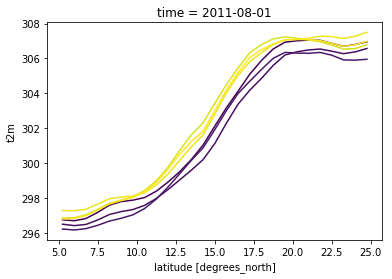

In [235]:
plt.figure()
cmap = mpl.cm.get_cmap('viridis')
ranges = np.array([0,1,2,30,31,32])
for r in ranges:
    perc = r / max(ranges)
    april[r,:].plot(color=cmap(perc))

In [276]:
def calc_month(m):
    srfc = cnst.ERA_MONTHLY_SRFC
    pl = cnst.ERA_MONTHLY_PL
    
    if (m < 5) | (m >= 10):  # box from where to detect max shear, max q, MCS trend variability
        box = [-12,12,5,9]
        mcs = cnst.GRIDSAT + 'aggs/box_13W-13E-4-8N_meanT-50_from5000km2.nc'
    else:
        box =[-12,12,9,20]
        mcs = cnst.GRIDSAT + 'aggs/box_13W-13E-10-18N_meanT-50_from5000km2.nc'
    #tpick = [-10,10,6,26]
    Tlons = [-10,15]
    
    mcs_temp = xr.open_dataset(mcs)
    mcs_temp = mcs_temp['tir']   # mcs Tmean per month in the box
    
    y1 = np.min(np.unique(mcs_temp['time.year'].values))
    y2 = np.max(np.unique(mcs_temp['time.year'].values))

    dam = xr.open_dataset(srfc)
    dam = u_darrays.flip_lat(dam)
    dam = dam.where((dam['time.year']>=y1) & (dam['time.year']<=y2), drop=True)
    dam = dam['t2m']
    tsouth = dam.sel(longitude=slice(Tlons[0], Tlons[1]), latitude=slice(5,10)).mean('longitude')  # temperature gradient detection
    tnorth = dam.sel(longitude=slice(10, 20), latitude=slice(10,22)).mean('longitude')
    tall = dam.sel(longitude=slice(-10, 20), latitude=slice(5,22)).mean('longitude')
    
    da_orig = xr.open_dataset(pl)
    da_orig = u_darrays.flip_lat(da_orig)
    da_orig = da_orig.where((da_orig['time.year']>=y1) & (da_orig['time.year']<=y2), drop=True)
    da = da_orig.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    
    u925 = da['u'].sel(level=slice(850, 925)).mean(dim='level').mean('longitude')
    u600 = da['u'].sel(level=slice(600, 700)).mean(dim='level').mean('longitude') 
    v925 = da['v'].sel(level=slice(850, 925)).mean(dim='level').mean('longitude')
    v600 = da['v'].sel(level=slice(600, 700)).mean(dim='level').mean('longitude')
    qq925 = da['q'].sel(level=slice(850,925)).mean(dim='level').mean('longitude')*1000
    qq600 = da['q'].sel(level=slice(600, 700)).mean(dim='level').mean('longitude')*1000
    
    months = [1,2,3,4,5,6,7,8,9,10,11,12]
    mnames = {1:'Jan',2:'Feb', 3 : 'Mar', 4 : 'April', 5 : 'May', 6:'Jun', 7:'Jul', 8:'Aug', 9 : 'Sep', 10 : 'Oct', 11:'Nov', 12:'Dec'}

    # pick month
    south = tsouth[(tsouth['time.month']==m)]
    north = tnorth[(tnorth['time.month']==m)]
    alls = tall[(tall['time.month']==m)]
    ulow = u925[(u925['time.month']==m)]
    uhigh = u600[(u600['time.month']==m)]
    
    vlow = v925[(v925['time.month']==m)]
    vhigh = v600[(v600['time.month']==m)]
    mcs_month = mcs_temp[mcs_temp['time.month']==m]
    qlow = qq925[(qq925['time.month']==m)]
    qmid = qq600[(qq600['time.month'] == m)]
    
    south_peryear = south.groupby('time.year').mean('time').min('latitude') # minimum T in south box per year
    north_peryear = north.groupby('time.year').mean('time').max('latitude') # maximum T in north box per year
    qlow_peryear = qlow.groupby('time.year').mean('time').max('latitude') # max q in box per year
    qmid_peryear = qmid.groupby('time.year').mean('time').max('latitude') # max q in box pear year
    
    tmax_loc = np.argmax(alls.mean('time').values)
    print('Tmax_loc', tmax_loc, alls.latitude.values[tmax_loc])
    alls = alls.isel(latitude=slice(0,tmax_loc))
    tslope_peryear = alls.squeeze().groupby('time.year').apply(linear_trend_lingress_single,nb_missing=10)

    tslopes = tslope_peryear * (np.max(alls.latitude.values)-np.min(alls.latitude.values))
    tdiff = alls.squeeze().groupby('time.year').max()-alls.squeeze().groupby('time.year').min()
    

    
    u925_peryear = ulow.groupby('time.year').mean('time')
    u600_peryear = uhigh.groupby('time.year').mean('time')
    v925_peryear = vlow.groupby('time.year').mean('time')
    v600_peryear = vhigh.groupby('time.year').mean('time')
    q = qlow_peryear
    qmid = qmid_peryear

    ### check where AEJ would be 
    da_movshear = da_orig.sel(longitude=slice(box[0], box[1]), latitude=slice(3,20))
    u600_mov = da_movshear['u'].sel(level=slice(600,700)).mean(dim='level').mean(['longitude'])
    uhigh_mov = u600_mov[(u600_mov['time.month']==m)]
    uhigh_mov = uhigh_mov.groupby('time.year').mean('time')

    aej_speed = uhigh_mov.min('latitude')
    aej_lat = []
    for uh in uhigh_mov:
        pos = np.argmin(uh.values)
        aej_lat.append(uh.latitude.values[pos])
    aej_lat = np.mean(aej_lat)
    #####
    
    tgrad = ((north_peryear-south_peryear))
    print('Mean tgrad', np.mean(tgrad.values))
    
#     plt.figure()
#     plt.plot(alls['time.year'].values, tslopes, label='slope')
#     plt.plot(alls['time.year'].values,tdiff, label='diff')
#     plt.plot(alls['time.year'].values,tgrad, label='northsouth')
#     plt.legend()
    
    ushear =u600_peryear-u925_peryear
    vshear =v600_peryear-v925_peryear
    
    shear = tgrad.copy(deep=True)
    shear.name = 'shear'
    uwind = tgrad.copy(deep=True)
    uwind.name = 'u'
    maxshear = []
    shearlat = []
    minu = []
    for us, vs in zip(ushear, vshear):
        ws_shear = u_met.u_v_to_ws_wd(us.values, vs.values)
        maxshear.append(np.max(ws_shear[0]))
        shearlat.append(ushear.latitude.values[np.argmax(ws_shear[0])])
        minu.append(np.min(us.values))
    
    shear.values = np.array(maxshear)
    uwind.values = np.array(minu)
    print('mean shear', np.mean(shear.values))
    print('shear lat', np.mean(shearlat), 'aej lat', aej_lat)
    
    #shear vs mcs correlation
    r = stats.pearsonr(shear.values[1::]-shear.values[0:-1],mcs_month.values[1::]-mcs_month.values[0:-1])
    #q vs mcs correlation
    rq = stats.pearsonr(q.values[1::]-q.values[0:-1],mcs_month.values[1::]-mcs_month.values[0:-1])
    rqm = stats.pearsonr(qmid.values[1::]-qmid.values[0:-1],mcs_month.values[1::]-mcs_month.values[0:-1])
    #shear vs tgrad correlation
    tshear_cor = stats.pearsonr(shear.values[1::]-shear.values[0:-1],tdiff.values[1::]-tdiff.values[0:-1])
    ru = stats.pearsonr(uwind.values[1::]-uwind.values[0:-1],mcs_month.values[1::]-mcs_month.values[0:-1])
#     #shear vs mcs correlation
#     r = stats.pearsonr(shear.values,mcs_month.values)
#     #q vs mcs correlation
#     rq = stats.pearsonr(q.values,mcs_month.values)
#     #shear vs tgrad correlation
#     tshear_cor = stats.pearsonr(shear.values,tgrad.values)

    #sslope, sint = ustats.linear_trend(shear)
    sslope, sint = u_stat.linear_trend(shear)

    try:
        mslope, mint = u_stat.linear_trend(mcs_month)

        if np.isnan(mslope):
            print(m, 'Shear trend not significant')
    except:
        print(m, 'Shear trend not significant')
        mslope = np.nan
        mint = np.nan
        #return

    mr = stats.pearsonr(np.arange(len(mcs_month)), mcs_month)
    print('linear regression for mcs cover', m, mr)
#     if mr[1]>0.01:
#         print('Not significant')
#         return

#     plt.figure()
#     plt.title(str(m))
#     plt.scatter(shear.values, tgrad.values, label='shear')
#     #plt.plot(tgrad.values, label='tgrad')
#     plt.legend()
#     plt.figure()
#     plt.scatter(q.values,mcs_month.values, label='q')
#     plt.legend()
#     plt.figure()
#     plt.scatter(shear.values, mcs_month.values, label='mcs')
#     plt.legend()
       
    return [shear,mcs_month,sint,sslope,r,mnames[m],rq, tgrad,mint, mslope, tshear_cor,q, ru, rqm]
    

Tmax_loc 22 21.75
Mean tgrad 9.534581
mean shear 12.791874
shear lat 14.807143 aej lat 14.335714
linear regression for mcs cover 8 (-0.7400575150044536, 3.759834422408905e-07)


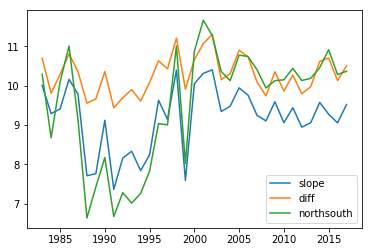

In [275]:
monthdic= calc_month(8)

In [285]:

monthdic= calc_month(5)
monthdic2 = calc_month(10)
monthdic3 = calc_month(8)
monthdic3 = calc_month(9)
monthdic3 = calc_month(6)

Tmax_loc 14 15.75
Mean tgrad 8.505936
mean shear 12.582858
shear lat 9.15 aej lat 8.185715
linear regression for mcs cover 5 (-0.4057825342035224, 0.015583223291372537)
Tmax_loc 14 15.75
Mean tgrad 5.9351344
mean shear 8.039191
shear lat 8.442857 aej lat 9.6214285
linear regression for mcs cover 10 (-0.694016246294677, 3.7729739000414046e-06)
Tmax_loc 22 21.75
Mean tgrad 9.534581
mean shear 12.791874
shear lat 14.807143 aej lat 14.335714
linear regression for mcs cover 8 (-0.7400575150044536, 3.759834422408905e-07)
Tmax_loc 18 18.75
Mean tgrad 8.591044
mean shear 11.592414
shear lat 13.435715 aej lat 13.114285
linear regression for mcs cover 9 (-0.6870158709057944, 5.164699461271279e-06)
Tmax_loc 16 17.25
Mean tgrad 10.026927
mean shear 14.197838
shear lat 11.957143 aej lat 11.142858
linear regression for mcs cover 6 (-0.6762868492947713, 8.221594583308317e-06)


In [277]:
rlist = [] # grad
mlist  = [] # mcs shear
qlist = [] # mcs q
qmlist = []
ulist = []
mcsmean = [] # mcs T drop
for mm in range(1,13):
    dic = calc_month(mm)
    rlist.append(dic[10][0])
    mlist.append(dic[4][0])
    qlist.append(dic[6][0])
    mcsmean.append(dic[9])
    ulist.append(dic[12][0])
    qmlist.append(dic[13][0])

Tmax_loc 4 8.25
Mean tgrad -0.92247486
mean shear 6.088061
shear lat 5.464286 aej lat 4.1571426
1 Shear trend not significant
linear regression for mcs cover 1 (nan, 1.0)
Tmax_loc 5 9.0
Mean tgrad 0.57485527
mean shear 7.6252527
shear lat 5.25 aej lat 3.7928572
linear regression for mcs cover 2 (-0.6645043391383609, 1.340882967215591e-05)
Tmax_loc 9 12.0
Mean tgrad 4.067463
mean shear 9.309877
shear lat 5.357143 aej lat 4.2642856
linear regression for mcs cover 3 (-0.45292200821148015, 0.006292191341867207)
Tmax_loc 11 13.5
Mean tgrad 6.9156213
mean shear 11.1226225
shear lat 7.392857 aej lat 5.742857
linear regression for mcs cover 4 (-0.5226684854967891, 0.0012769512300540233)
Tmax_loc 14 15.75
Mean tgrad 8.505936
mean shear 12.582858
shear lat 9.15 aej lat 8.185715
linear regression for mcs cover 5 (-0.4057825342035224, 0.015583223291372537)
Tmax_loc 16 17.25
Mean tgrad 10.026927
mean shear 14.197838
shear lat 11.957143 aej lat 11.142858
linear regression for mcs cover 6 (-0.6762868

In [278]:
mlist

[nan,
 -0.6331341,
 -0.6940209,
 -0.31734228,
 -0.49142596,
 -0.3858735,
 -0.49598387,
 -0.5560464,
 -0.4059758,
 0.06345057,
 -0.4894076,
 -0.4407379]

In [279]:
rlist

[0.6700699984420326,
 0.6933743906327626,
 0.6131735288166568,
 0.8008401869438754,
 0.826093786725328,
 0.809928193660392,
 0.4741987151311581,
 0.5885343252491586,
 0.8217301886731627,
 0.5893290765231549,
 0.5783012719467405,
 0.24475701806183667]

In [280]:
ulist

[nan,
 0.63200665,
 0.6850438,
 0.32319316,
 0.48646307,
 0.4536182,
 0.5265503,
 0.5548195,
 0.40425736,
 -0.05067609,
 0.49424064,
 0.48645866]

In [281]:
mlist = np.array(mlist)
mlist[np.array([0,-1])] = 0
qlist = np.array(qlist)
qlist[np.array([0,-1])] = 0
rlist = np.array(rlist)
rlist[np.array([0,-1])] = 0
ulist = np.array(ulist)
ulist[np.array([0,-1])] = 0

In [282]:
qlist

array([ 0.        , -0.4092751 , -0.30719662,  0.06428888, -0.18658786,
       -0.21163207, -0.36995095,  0.04752387, -0.05847883, -0.63977635,
       -0.37275475,  0.        ], dtype=float32)

In [283]:
# shear and q correlate in march but MCS cooling explanation is dominated by shear
stats.pearsonr(monthdic[0].values[1::]-monthdic[0].values[0:-1],monthdic[11].values[1::]-monthdic[11].values[0:-1])

(-0.19816515, 0.2612434388550306)

In [284]:
#March: MCS temperature correlation with q, shear effect removed is low
u_stat.pcor(monthdic[11].values[1::]-monthdic[11].values[0:-1],
              monthdic[1].values[1::]-monthdic[1].values[0:-1],
             monthdic[0].values[1::]-monthdic[0].values[0:-1])

(-0.07692107956878456, 0.6704931804067615)

In [286]:
#March: MCS temperature correlation with shear, q effect removed is high
u_stat.pcor(monthdic[0].values[1::]-monthdic[0].values[0:-1],
              monthdic[1].values[1::]-monthdic[1].values[0:-1],
             monthdic[11].values[1::]-monthdic[11].values[0:-1])

(-0.46281539680690725, 0.006685990282729368)

In [287]:
# in october, shear and q do not correlate. 
stats.pearsonr(monthdic2[0].values[1::]-monthdic2[0].values[0:-1],monthdic2[11].values[1::]-monthdic2[11].values[0:-1])

(0.31990322, 0.065128917981814)

In [288]:
#October: MCS temperature correlation with q, shear effect removed is very high
u_stat.pcor(monthdic2[11].values[1::]-monthdic2[11].values[0:-1],
              monthdic2[1].values[1::]-monthdic2[1].values[0:-1],
             monthdic2[0].values[1::]-monthdic2[0].values[0:-1])

(-0.698091748546348, 6.285906034859166e-06)

In [289]:
# October: MCS temperature correlation with shear, q effect removed is low
u_stat.pcor(monthdic2[0].values[1::]-monthdic2[0].values[0:-1],
              monthdic2[1].values[1::]-monthdic2[1].values[0:-1],
             monthdic2[11].values[1::]-monthdic2[11].values[0:-1])

(0.36820504112789454, 0.035002647252538904)

In [290]:
monthdic[7]

<xarray.DataArray 't2m' (year: 35)>
array([ 8.913269,  9.93811 ,  9.138245,  8.169861,  7.749603,  8.059326,
        7.153625,  9.216064,  9.199463,  8.175079,  8.135803,  8.19278 ,
        8.059052,  9.220184,  8.113556,  9.042847,  8.114594,  8.129028,
        8.927216,  8.267426,  7.075287, 10.200317,  8.213898,  8.963959,
        9.068573,  8.509308,  7.752228,  9.087524,  7.793243,  8.807739,
        8.574615,  8.468719,  8.242249,  8.72583 ,  8.309113], dtype=float32)
Coordinates:
  * year     (year) int64 1983 1984 1985 1986 1987 ... 2013 2014 2015 2016 2017

In [291]:
cmean.max()

<xarray.DataArray 'tir' ()>
array(1.902398)

In [292]:
contour = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : strend_ns.transpose().values,  # /shearmean.transpose().values)*100
           'levels' : [-0.6,-0.4,-0.2,0.2,0.4, 0.6] , 'cmap' : 'viridis', 'colors' : 'k'} #  [-0.5,-0.3,-0.1,0.1,0.3,0.5] np.array([-14,-8,-2,2,8,14])

# contour3 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : shearmean.transpose(), 
#             'levels' : np.linspace(np.min(shearmean),np.max(shearmean),6), 'cmap' : 'Greys', 'colors' : 'r'} #np.array([-0.75, -0.6, -0.45])*-1

# contour2 = {'x' : cmean.month, 'y' : cmean.lat, 'data' : cmean.transpose(),  #qmean.transpose()
#            'levels' : np.linspace(1,5,6), 'cmap' : 'Greys', 'colors' : 'k'} #np.array([-0.75, -0.6, -0.45])*-1

contour2 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : qmean.transpose(),  #qmean.transpose()
           'levels' : np.linspace(14,16,6), 'cmap' : 'Greys', 'colors' : 'k'}


contour3 = None
mask_sig = (qtrend.transpose()>0.1).astype(int) 

mask_sig2 = (strend_ns.transpose()>0.3).astype(int) 
#mask_sig2 = (strend_ns.transpose()>0.1).astype(int) 

In [293]:
monthdic[1]

<xarray.DataArray 'tir' (time: 35)>
array([-65.2067  , -65.343575, -67.0205  , -63.023663, -63.42414 , -64.412575,
       -65.668335, -65.356255, -65.68948 , -62.579132, -66.81513 , -64.739044,
       -63.732433, -65.60971 , -64.131516, -66.23291 , -65.23782 , -66.033295,
       -67.81437 , -64.00684 , -65.70211 , -67.52756 , -62.175114, -64.97855 ,
       -67.44282 , -66.82379 , -64.58296 , -66.597496, -67.181725, -65.90173 ,
       -67.05716 , -65.98059 , -67.51735 , -67.37752 , -65.29242 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1983-05-31 1984-05-31 ... 2017-05-31

In [294]:
qlist

array([ 0.        , -0.4092751 , -0.30719662,  0.06428888, -0.18658786,
       -0.21163207, -0.36995095,  0.04752387, -0.05847883, -0.63977635,
       -0.37275475,  0.        ], dtype=float32)

/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Tmax_loc 9 12.0
Mean tgrad 4.067463
mean shear 9.309877
shear lat 5.357143 aej lat 4.2642856
linear regression for mcs cover 3 (-0.45292200821148015, 0.006292191341867207)
Tmax_loc 14 15.75
Mean tgrad 5.9351344
mean shear 8.039191
shear lat 8.442857 aej lat 9.6214285
linear regression for mcs cover 10 (-0.694016246294677, 3.7729739000414046e-06)


/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


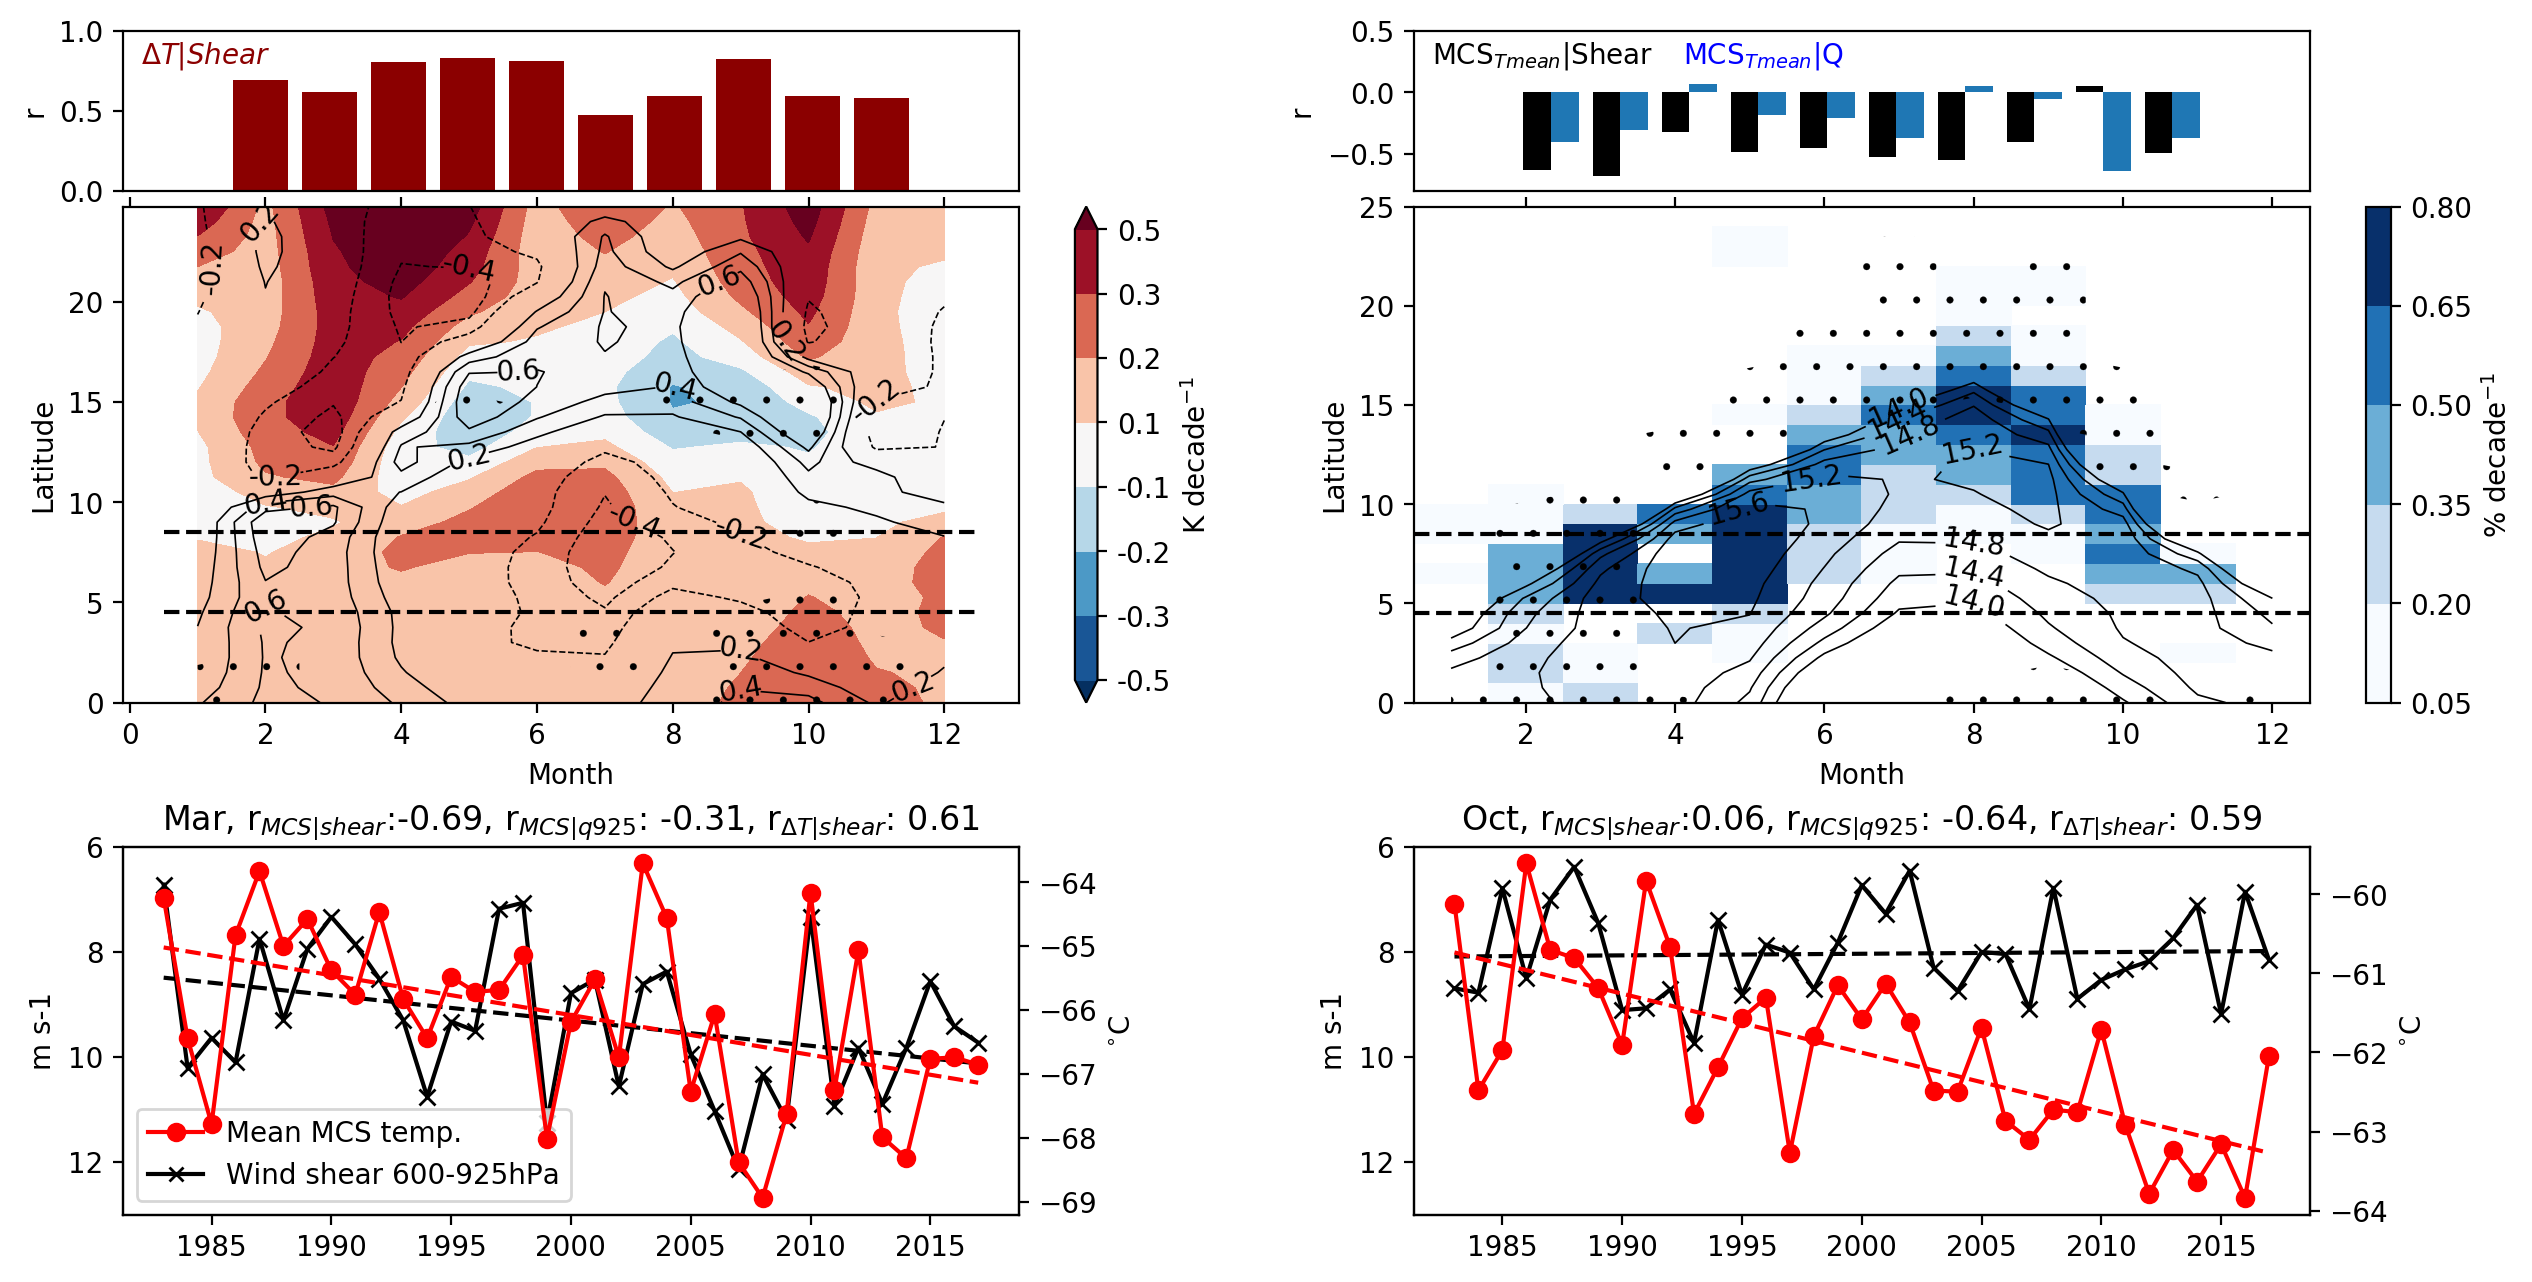

In [297]:
f=plt.figure(figsize=(14,8), dpi=200)  # this opens a plot window


left, width, width2 = 0.061, 0.4, 0.32
bottom, height, height2 = 0.09, 0.31, 0.23
space1=0.09
space2=0.01
bottom_h = bottom+height2+space1
bottom_h2 = bottom+height + height2 +space1+space2

rect_scatter1 = [left, bottom_h, width, height]
rect_scatter2 = [left+width+left, bottom_h, width, height]

rect_histx1 = [left, bottom_h2, width2, 0.1]
rect_histx2 = [left+width+left, bottom_h2, width2, 0.1]

line1 = [left, bottom, width2, height2]
line2 = [left+width+left, bottom, width2, height2]

#ax = f.add_subplot(221) #plt.axes(rect_histx1) #  # this opens a new plot axis
ax = plt.axes(rect_histx1)

bbar = ax.bar(ttrend.month,rlist, align='center', color='darkred')
ax.set_ylim(0,1)
plt.gca().set_xticks([])
plt.ylabel('r')
ax.text(0.02,0.8,'${\Delta T|Shear}$', color='darkred', transform=ax.transAxes)
qlistt = np.array(qlist).copy()
# qlistt[3] = qlistt[3]-0.5
# qlistt[4] = qlistt[4]-0.6
ax1 = plt.axes(rect_histx2)
bbar = ax1.bar(ttrend.month-0.2,np.array(ulist)*-1, align='center', width=0.4,color='k') # mlist
bbar = ax1.bar(ttrend.month+0.2,qlistt, align='center', width=0.4)
plt.gca().set_xticks([])
plt.ylabel('r')
ax1.text(0.02,0.8,'MCS$_{Tmean}$|Shear', color='k', transform=ax1.transAxes)
ax1.text(0.3,0.8,'MCS$_{Tmean}$|Q', color='b', transform=ax1.transAxes)
ax1.set_ylim(-0.8,0.5)

ax2 = plt.axes(rect_scatter1)
mapp = ax2.contourf(ttrend.month, era_trend.latitude, ttrend.transpose(),                   
                   cmap='RdBu_r', extend='both', levels=np.linspace(-0.45,0.45,8))  # this is the actual plot

  # this is the actual plot

mpl.rcParams['hatch.linewidth'] = 0.1

## mask for significance indicator
if mask_sig is not None:
     plt.contourf(ttrend.month, era_trend.latitude, mask_sig, colors='none', hatches='..',
                 levels=[0.5, 1], linewidth=0.1)  
        
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
        
        
## additional contour on plot   
# if contour is not None:
#     cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
#                     cmap=contour['cmap'] ) 

#    plt.clabel(cs, inline=1, fontsize=10)

## additional contour on plot   
if contour is not None:
    cs = ax2.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
                    colors=contour['colors'] , linewidths=0.6) 

    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f") #"%d"

#plt.title('Trends in T925 (shading) and shear (contour)')

plt.hlines(4.5,0.5,12.5, linestyles='dashed', color='k')
plt.hlines(8.5,0.5,12.5, linestyles='dashed', color='k')
plt.xlabel('Month')
plt.ylabel('Latitude')
# Countries
cbar = plt.colorbar(mapp, format="%1.1f", )  # adds colorbar
cbar.set_label( 'K decade$^{-1}$')

###############################

#ax = f.add_subplot(222)#plt.axes(rect_histx2)#f.add_subplot(222)  # this opens a new plot axis
ax3 = plt.axes(rect_scatter2)

cmapp = uplot.discrete_cmap(5, base_cmap='Blues')
#mapp = ax.contour(ttrend.month, era_trend.latitude, tmean.transpose()-273.15, 
#                  cmap='Reds', extend='both', levels=np.linspace(20,35,4), linestyles='dotted')  # this is the actual plot
#plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")


mappable = ax3.pcolormesh(np.arange(0.5,13,1), np.arange(0,26,1),da.sel(lat=slice(0,25)).values
                          ,cmap=cmapp, vmin=0.05, vmax=0.80)

# mappable = ax3.pcolormesh(np.arange(0.5,13,1), ccover_trend.lat,ctrend.transpose()
#                           ,cmap=cmapp, vmin=0.05, vmax=0.80)

cbar = plt.colorbar(mappable, ticks=np.linspace(0.05,0.80,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('% decade$^{-1}$')
plt.hlines(4.5,0.5,12.5, linestyles='dashed')
plt.hlines(8.5,0.5,12.5, linestyles='dashed')
plt.xlabel('Month')
plt.ylabel('Latitude')

ax3.contourf(ttrend.month, era_trend.latitude, mask_sig2, colors='none', hatches='.',
                 levels=[0.5, 1], linewidth=0.05)


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

#plt.title('Trends in -70C MCS-cover(shading) and mean shear (contour)')

#ipdb.set_trace()
# cs = ax.contour(np.arange(0.5,12,1), np.arange(0,25,1), mean.sel(lat=slice(0,25)), cmap='viridis' , levels=np.arange(0.5,4.5,1.5)) 
# plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

# mapp = ax.contour(ttrend.month, era_trend.latitude, umean.transpose(), 
#                    cmap='Reds', extend='both', levels=np.linspace(-10,-5,3), linestyles='dashed')  # this is the actual plot
# plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")

if contour2 is not None:
    cs = ax3.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], 
                    colors=contour2['colors'] , linewidths=0.6) 
    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
    
if contour3 is not None:    
    cs = ax3.contour(contour3['x'], contour3['y'], contour3['data'], levels=contour3['levels'], 
                    colors=contour3['colors'] , linewidths=0.6) 
    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

################################

#ax = f.add_subplot(223)  # this opens a new plot axis
ax4 = plt.axes(line1)
m = 3
monthdic = calc_month(m)

x = np.arange(0,len(monthdic[0]))
rr = monthdic[4][0]
ax4.plot(monthdic[7].year, monthdic[0], 'x-', label='Wind shear 600-925hPa', color='k')
ax4.plot(monthdic[7].year, monthdic[2] + x*monthdic[3], '--', color='k')
ax4.set_ylim(6,13)
ax4.set_ylim(ax4.get_ylim()[::-1])
ax5 = ax4.twinx()
ax5.plot(monthdic[1]['time.year'],monthdic[1], 'o-', label='Mean MCS temp.', color='r')
ax5.plot(monthdic[7].year, monthdic[8] + x*monthdic[9], '--', color='r')
mcsline = lines.Line2D([],[], color='r', label='Mean MCS temp.', linestyle='solid', marker='o')
shearline = lines.Line2D([],[], color='k', label='Wind shear 600-925hPa', linestyle='solid', marker='x', markersize=5)
ax5.set_ylabel('$^{\circ}$C')
ax4.set_ylabel('m s-1')

ax4.set_title(monthdic[5]+', r$_{MCS|shear}$:'+ str(np.round(rr, decimals=2)) +', r$_{MCS|q925}$: ' 
             + str(np.round(monthdic[6][0], decimals=2)) + ', r$_{\Delta T|shear}$: ' + str(np.round(monthdic[10][0], decimals=2)))
if m==3:
    ax4.legend(handles=[mcsline, shearline], loc='lower left')
    
#################################
ax6 = plt.axes(line2)
#ax = f.add_subplot(224)  # this opens a new plot axis
m = 10
monthdic = calc_month(m)

x = np.arange(0,len(monthdic[0]))
rr = monthdic[4][0]
ax6.plot(monthdic[7].year, monthdic[0], 'x-', label='Wind shear 600-925hPa', color='k')
ax6.plot(monthdic[7].year, monthdic[2] + x*monthdic[3], '--', color='k')
#ax.set_ylim(-15,-5)

ax6.set_ylim(6,13)
ax6.set_ylim(ax6.get_ylim()[::-1])

ax7 = ax6.twinx()
ax7.plot(monthdic[1]['time.year'],monthdic[1], 'o-', label='Mean MCS temp.', color='r')
ax7.plot(monthdic[7].year, monthdic[8] + x*monthdic[9], '--', color='r')
mcsline = lines.Line2D([],[], color='r', label='Mean MCS temp.', linestyle='solid', marker='o')
shearline = lines.Line2D([],[], color='k', label='Wind shear 600-925hPa', linestyle='solid', marker='x', markersize=5)
ax7.set_ylabel('$^{\circ}$C')
ax6.set_ylabel('m s-1')


ax6.set_title(monthdic[5]+', r$_{MCS|shear}$:'+ str(np.round(rr, decimals=2)) +', r$_{MCS|q925}$: ' 
             + str(np.round(monthdic[6][0], decimals=2)) + ', r$_{\Delta T|shear}$'': ' + str(np.round(monthdic[10][0], decimals=2)))
if m==3:
    ax6.legend(handles=[mcsline, shearline], loc='lower left')
    
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/CLOVER/fig1.jpg')